# CmpE 482 - Final Projects
### Ahmet Ercan Tekden

## Project 1 - Interpolatation with Autoregressive(AR) models


### Step 1 
Read the flights.csv file into two column vectors T and X, where X is partially observed monthly totals of international airline passengers and T is the corresponding months.

Plot T vs. X

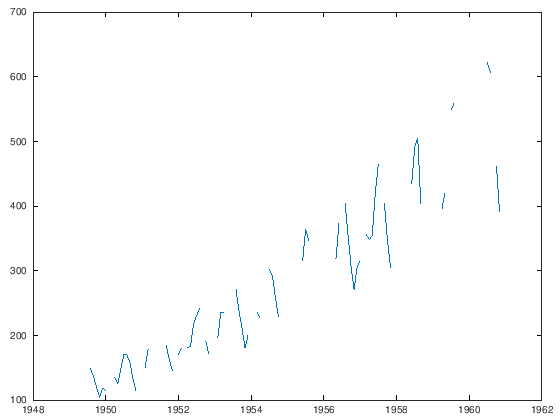

In [1]:
filename = 'flights.csv';
delimiterIn = ',';
Data = importdata(filename,delimiterIn);
T= Data.data(:,1);
X= Data.data(:,2);

plot(T,X)

### Settings

In [2]:
Unknown_x_indices = find(isnan(X));
M= 4;
N=length(X);
GX=zeros(N-M,M);
GA=zeros(N-M,N);

### Iteration Part

In [3]:
X_temp=X;
X_temp(Unknown_x_indices)=0;
for i=1:100
    %% Setting X_obs 
    X_obs=X_temp;
    X_obs(Unknown_x_indices)=0;

    %% Setting Gx and finding A.

    for i=1:N-M
        GX(i,:)=fliplr(X_temp(i:i+M-1)');
    end
    
    %% Solving A with QR
    [QGX RGX] = qr(GX);
    A= (RGX)\(QGX'*X_temp(M+1:end));  
    
    %% Setting Ga
    for i=1:N-M
        GA(i,i:i+M)=[-fliplr(A') 1];
    end
    
    %% Solve for X_mi
    % If we think equation as Ax=b
    % A,x,b becomes A=GA(X_mi indexes),x=X_mi b=-GA*X_obs
    [QGA RGA] = qr(GA(:,Unknown_x_indices));
    % We can directly write -GA * X_obs because X_mi corresponding indexes of b will become 0 after multiplication.
    b = (-GA* X_obs);
    X_mi= (RGA)\(QGA'*b);
    X_temp(Unknown_x_indices)=X_mi; %% Update indexes of X_mi
end

X_new = X_temp;


### Plots

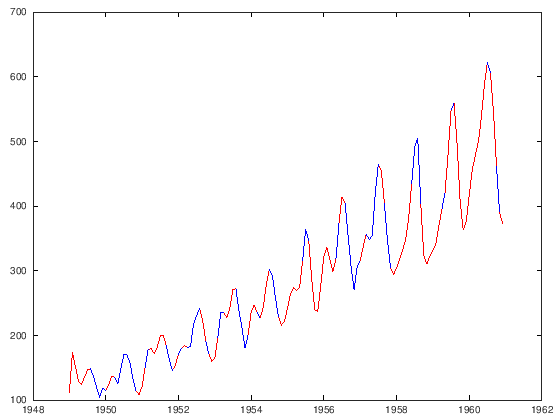

In [4]:
%% Plot T with X
figure;
plot(T,X_temp,'r');
hold on;
plot(T,X,'b');
hold on;

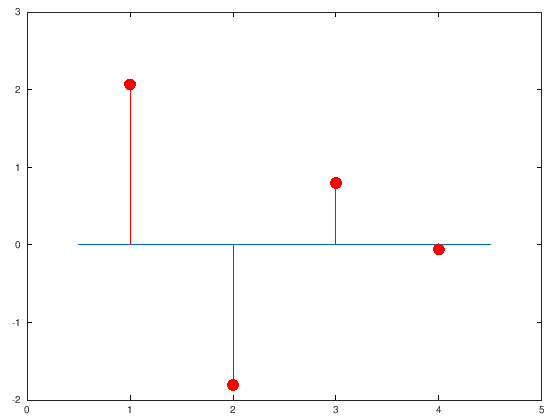

In [5]:
%% Plot A with reference line on X axis.
figure;
plot([0.5,4.5],[0,0]);
hold on;
scatter([1:4],A,1000,'r','filled');
hold on;
for i=1:4
    plot([i,i],[0,A(i)],'r');
    hold on;
end

# Project 2

Read the stones_rgb.jpg into a tensor X ∈ $R^{64×64×3}$ where the color intensity of channel
c (red, green, or blue) at pixel (x, y) is denoted by $X_{xyc}$ (see: imread). Then, plot the
image (see: imshow).


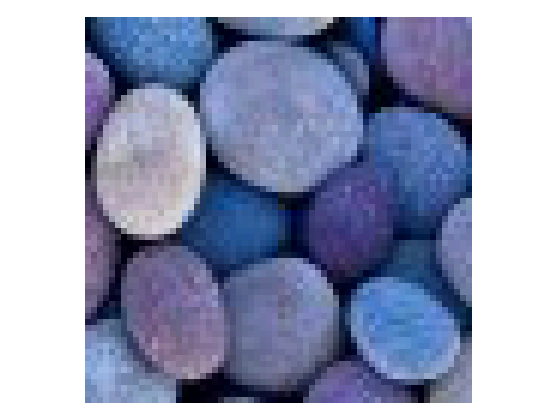

In [6]:
image = imread('stones_rgb.jpg');
imshow(image);

### Construct Similarity matrix

In [7]:
% Parameters
h=64;
N=h*h;
concattedImage=zeros(N,3);
SimM=zeros(N,N);
r=2;
sigma=10;
W=[ 0.299 0.587 0.114 ; -0.14713 -0.28886 0.436 ; 0.615 -0.51499 -0.10001];
%% I couldn't find the shortcut for this operation.
% 64*64*4*4 op.
for x1=1:h
    for y1=1:h
        for x2=max(1,x1-r):min(h,x1+r)
            for y2=max(1,y1-r):min(h,y1+r)
                v=abs(double(squeeze(image(x1,y1,:))) - double(squeeze(image(x2,y2,:))));
                simM(x1+h*(y1-1),x2+h*(y2-1))=exp(-(norm(W*v)^2)/(2*sigma^2));
            end
        end
    end
end
% SimMatrix=0 on diagonal.
for i=1:N
    simM(i,i)=0;
end


### Define laplacian matrix

In [8]:
%% Diagonal degree matrix
D=diag(sum(simM,2));
D_term= sqrt(D)\eye(N);
%% Laplacian Matrix
L= D_term * simM * D_term;

### Calculate eigenvectors of Laplacian matrix.

In [9]:
k=5;
%% Calculate eigenvectors
[Q,R] = qr(randn(N,k), 0);

for i=1:1000,
    Z = L*Q;
    [Q, R] = qr(Z,0);
end
%% Calculate V
V=  D_term*Q;

### Plots

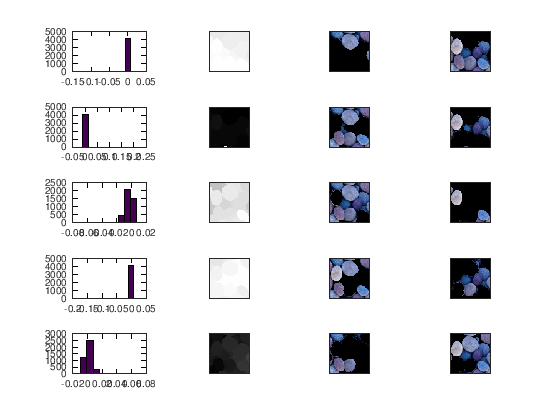

In [10]:
%% Plots
for i=1:k
    %Histogram
    subplot(k,4,(i-1)*4+1);
    hist(V(:,i));
    % Greyscale plot.
    subplot(k,4,(i-1)*4+2);
    Vkreshaped=reshape(V(:,i),64,64);
    %% Normalization of matrix between 0-1.
    imVkreshaped=(Vkreshaped-min(V(:,i)))/(max(V(:,i))-min(V(:,i)));
    imshow(repmat(imVkreshaped,1,1,3));
    % Cluster 1
    subplot(k,4,(i-1)*4+3);
    cluster1=image;
    indexes1=repmat(Vkreshaped>0,1,1,3);
    cluster1(indexes1)=0;
    imshow(cluster1);
    % Cluster 2
    subplot(k,4,(i-1)*4+4);
    cluster2=image;
    indexes2=repmat(Vkreshaped<0,1,1,3);
    cluster2(indexes2)=0;
    imshow(cluster2);
end

### Bonus, Segments

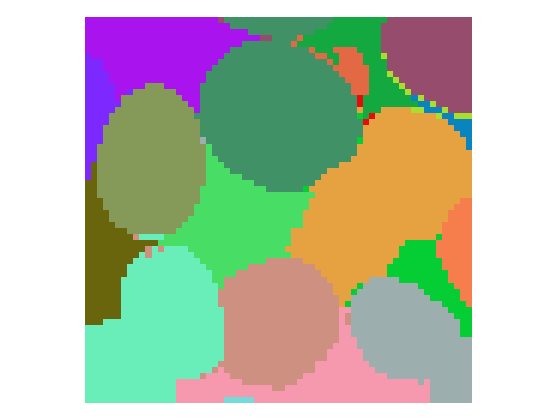

In [17]:
pkg load statistics
Vnorm=V;
% Normalization
for i=1:N
    Vnorm(i,:)=V(i,:)/norm(V(i,:));
end
% Create Clusters 
clusters=kmeans(Vnorm,20);
% Create random 20 colors.
colors=(rand(20,3));
clusterReshaped=reshape(clusters,64,64);
clusterImage=zeros(64,64,3);
% Create a new image with clusters.
for i=1:64
    for j=1:64
        clusterImage(i,j,:)=colors(clusterReshaped(i,j),:);
    end
end
imshow(clusterImage);